# 06: Evaluate LLMs for Systematic Review Screening

## Objective
Evaluate whether LLMs can correctly determine if a paper should be **included** or **excluded** from a Cochrane systematic review.

## Task
Given:
- **Review context** (title + abstract of the Cochrane review - defines the screening criteria)
- **Paper abstract** (the candidate study being screened)

Predict: INCLUDE or EXCLUDE

## Dataset
- **Validation set**: `ground_truth_validation_dataset.csv` - All Cochrane groups with `cochrane_group` column for filtering
- **Evaluation subset**: Public Health group only (4,089 records) - domain-relevant to UKHSA

## Prompt Types
1. **Zero-shot** - Direct question without reasoning
2. **Chain-of-thought (CoT)** - Ask the LLM to reason step-by-step before deciding

## Models (10 Models - All Local via Ollama)

### General-Purpose Models
| Model | Size | Description |
|-------|------|-------------|
| **Llama 3.2** | 3B | Meta's efficient baseline model |
| **Llama 3.1 8B** | 8B | Stronger instruction-following |
| **Mistral 7B** | 7B | Strong general-purpose model |
| **Mixtral 8x7B** | 46.7B (MOE) | Mixture of Experts, very powerful |
| **Qwen 2.5 14B** | 14B | Top benchmarks, rivals GPT-4 |
| **Gemma 2 9B** | 9B | Google's latest, excellent classification |
| **Phi-3 Medium** | 14B | Microsoft's efficient model |

### Biomedical-Specialized Models
| Model | Size | Description |
|-------|------|-------------|
| **OpenBioLLM-8B** | 8B | Llama-3 fine-tuned, outperforms GPT-3.5 on medical |
| **BioMistral 7B** | 7B | Mistral fine-tuned on PubMed Central |
| **Meditron 7B** | 7B | Fine-tuned on medical guidelines & PubMed |

## Output
- `Data/results/eval_*.csv` - Predictions with LLM reasoning saved
- Metrics: Accuracy, Precision, Recall, F1, Sensitivity, Specificity

**IMPORTANT:** All inference is local via Ollama - no data sent to external APIs.

In [1]:
# Install required packages for local LLM inference
%pip install -q ollama pandas scikit-learn tqdm

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Setup and load data
import os
from pathlib import Path
import pandas as pd
import ollama
from tqdm.notebook import tqdm
from datetime import datetime
import time

notebook_dir = Path.cwd()
project_root = notebook_dir if (notebook_dir / "Data").exists() else notebook_dir.parent
DATA_DIR = project_root / "Data"
RESULTS_DIR = DATA_DIR / "results"
RESULTS_DIR.mkdir(exist_ok=True)

GROUND_TRUTH_CSV = DATA_DIR / "ground_truth_validation_dataset.csv"

# Load validation set (all Cochrane groups, filterable by cochrane_group column)
ground_truth = pd.read_csv(GROUND_TRUTH_CSV)
print(f"Loaded validation set: {len(ground_truth):,} examples")
print(f"\nLabel distribution:")
print(f"  Included: {(ground_truth['label'] == 1).sum():,}")
print(f"  Excluded: {(ground_truth['label'] == 0).sum():,}")
print(f"\nUnique reviews: {ground_truth['review_doi'].nunique():,}")
print(f"\nCochrane groups available (filter with cochrane_group column):")
print(ground_truth['cochrane_group'].value_counts().to_string())

Loaded validation set: 41,692 examples

Label distribution:
  Included: 14,738
  Excluded: 26,954

Unique reviews: 1,228

Cochrane groups available (filter with cochrane_group column):
cochrane_group
Acute Respiratory Infections    11455
Tobacco Addiction               10198
Infectious Diseases              8516
Drugs and Alcohol                6754
Public Health                    4089
STI                               680


In [3]:
# Check available Ollama models
try:
    models = ollama.list()
    print("Available local models:")
    if hasattr(models, 'models'):
        for model in models.models:
            name = model.model if hasattr(model, 'model') else str(model)
            print(f"  - {name}")
    elif isinstance(models, dict) and 'models' in models:
        for model in models['models']:
            name = model.get('name', model.get('model', str(model)))
            print(f"  - {name}")
    else:
        print(f"  Models: {models}")
except Exception as e:
    print(f"Error connecting to Ollama: {e}")
    print("Make sure Ollama is running: ollama serve")

Available local models:
  - mixtral:latest
  - qwen2.5:14b
  - mistral-nemo:12b
  - meditron:7b
  - phi3:medium
  - gemma2:9b
  - qwen2.5:7b
  - llama3.1:8b
  - cniongolo/biomistral:latest
  - koesn/llama3-openbiollm-8b:latest
  - mistral:latest
  - llama3.2:latest


In [4]:
# =============================================================================
# Prompt Templates - Include Review Context!
# =============================================================================

ZERO_SHOT_PROMPT = """You are a systematic review screening assistant. Your task is to determine whether a candidate paper should be INCLUDED or EXCLUDED from a specific Cochrane systematic review.

=== COCHRANE REVIEW ===
Title: {review_title}

Abstract/Objective: {review_abstract}

=== CANDIDATE PAPER ===
Title: {paper_title}

Abstract: {paper_abstract}

=== TASK ===
Based on the review's objectives and inclusion criteria, should this paper be INCLUDED or EXCLUDED?

Respond with only: INCLUDE or EXCLUDE"""


COT_PROMPT = """You are a systematic review screening assistant. Your task is to determine whether a candidate paper should be INCLUDED or EXCLUDED from a specific Cochrane systematic review.

=== COCHRANE REVIEW ===
Title: {review_title}

Abstract/Objective: {review_abstract}

=== CANDIDATE PAPER ===
Title: {paper_title}

Abstract: {paper_abstract}

=== TASK ===
Think step by step:
1. What is the review looking for? (population, intervention, outcomes)
2. What does the candidate paper study?
3. Does the paper match the review's criteria?

After your reasoning, give your final answer on a new line as: DECISION: INCLUDE or DECISION: EXCLUDE"""


def create_prompt(row: pd.Series, use_cot: bool = False) -> str:
    """Create prompt with review context and paper abstract."""
    template = COT_PROMPT if use_cot else ZERO_SHOT_PROMPT
    return template.format(
        review_title=str(row['review_title'])[:500],
        review_abstract=str(row['review_abstract'])[:2000],
        paper_title=str(row['paper_title'])[:300],
        paper_abstract=str(row['paper_abstract'])[:2000]
    )

# Preview a prompt
sample = ground_truth.iloc[0]
print("=" * 60)
print("SAMPLE ZERO-SHOT PROMPT:")
print("=" * 60)
print(create_prompt(sample, use_cot=False)[:1500] + "...")

SAMPLE ZERO-SHOT PROMPT:
You are a systematic review screening assistant. Your task is to determine whether a candidate paper should be INCLUDED or EXCLUDED from a specific Cochrane systematic review.

=== COCHRANE REVIEW ===
Title: Acupuncture for smoking cessation.

Abstract/Objective: Acupuncture is promoted as a treatment for smoking cessation, and is believed to reduce withdrawal symptoms. The objective of this review is to determine the effectiveness of acupuncture in smoking cessation in comparison with: a) sham acupuncture b) other interventions c) no intervention. We searched the Cochrane Tobacco Addiction Group trials register, Medline, PsycLit, Dissertation Abstracts, Health Planning and Administration, Social SciSearch, Smoking & Health, Embase, Biological Abstracts and DRUG. Randomised trials comparing a form of acupuncture with either sham acupuncture, another intervention or no intervention for smoking cessation. We extracted data in duplicate on the type of subjects, th

In [5]:
# =============================================================================
# Evaluation Functions - Save full reasoning
# =============================================================================
import re

def extract_decision(response: str) -> int:
    """Extract INCLUDE (1) or EXCLUDE (0) from LLM response."""
    response_upper = response.upper()
    
    # Look for explicit DECISION: pattern first (CoT)
    decision_match = re.search(r'DECISION:\s*(INCLUDE|EXCLUDE)', response_upper)
    if decision_match:
        return 1 if decision_match.group(1) == 'INCLUDE' else 0
    
    # Fall back to last occurrence
    include_pos = response_upper.rfind('INCLUDE')
    exclude_pos = response_upper.rfind('EXCLUDE')
    
    if include_pos > exclude_pos:
        return 1
    elif exclude_pos > include_pos:
        return 0
    
    return -1  # Could not determine


def run_evaluation(model_name: str, data: pd.DataFrame, use_cot: bool = False) -> pd.DataFrame:
    """Run evaluation and save full LLM reasoning."""
    results = []
    prompt_type = 'cot' if use_cot else 'zero_shot'
    
    for idx, row in tqdm(data.iterrows(), total=len(data), desc=f"{model_name} ({prompt_type})"):
        prompt = create_prompt(row, use_cot=use_cot)
        
        try:
            start = time.time()
            response = ollama.generate(model=model_name, prompt=prompt)
            elapsed = time.time() - start
            response_text = response.get('response', '')
            prediction = extract_decision(response_text)
        except Exception as e:
            response_text = f"ERROR: {e}"
            prediction = -1
            elapsed = 0
        
        results.append({
            'review_doi': row['review_doi'],
            'study_id': row['study_id'],
            'label': row['label'],
            'prediction': prediction,
            'correct': prediction == row['label'],
            'reasoning': response_text,  # Full LLM reasoning saved!
            'response_time_sec': round(elapsed, 2)
        })
    
    return pd.DataFrame(results)


print("Evaluation functions defined.")

Evaluation functions defined.


In [6]:
# =============================================================================
# Setup: Define eval_data and all_results
# =============================================================================
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Filter to Public Health Cochrane group only (4,089 records)
eval_data = ground_truth[ground_truth['cochrane_group'] == 'Public Health'].copy()

print(f"Evaluation dataset: {len(eval_data):,} Public Health samples")
print(f"  Included: {(eval_data['label'] == 1).sum():,} ({(eval_data['label'] == 1).mean()*100:.1f}%)")
print(f"  Excluded: {(eval_data['label'] == 0).sum():,} ({(eval_data['label'] == 0).mean()*100:.1f}%)")

# Dictionary to store all results (will be populated by evaluation cells)
all_results = {}
print("\n✓ eval_data and all_results initialized. Run individual evaluation cells below.")

Evaluation dataset: 4,089 Public Health samples
  Included: 848 (20.7%)
  Excluded: 3,241 (79.3%)

✓ eval_data and all_results initialized. Run individual evaluation cells below.


In [ ]:
# =============================================================================
# Llama 3.2 - Zero-Shot
# =============================================================================
MODEL_NAME = "llama3.2"
PROMPT_TYPE = "zero_shot"
print(f"{'='*60}\n{MODEL_NAME} ({PROMPT_TYPE})\n{'='*60}")

results = run_evaluation(MODEL_NAME, eval_data, use_cot=False)
all_results[f'{MODEL_NAME}_{PROMPT_TYPE}'] = results

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = RESULTS_DIR / f"eval_{MODEL_NAME}_{PROMPT_TYPE}_{timestamp}.csv"
results.to_csv(output_file, index=False)

valid = results[results['prediction'] != -1]
print(f"\n✓ Saved: {output_file.name}")
print(f"Results ({len(valid)} valid): Acc={accuracy_score(valid['label'], valid['prediction']):.3f}, "
      f"Prec={precision_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"Rec={recall_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"F1={f1_score(valid['label'], valid['prediction'], zero_division=0):.3f}")


EVALUATING: mistral

ZERO-SHOT EVALUATION


mistral (zero_shot):   0%|          | 0/4089 [00:00<?, ?it/s]


✓ Saved to eval_mistral_zero_shot_20260208_010650.csv

Zero-shot results (4045 valid predictions):
  Accuracy: 0.409
  Precision: 0.242
  Recall: 0.867
  F1: 0.378

CHAIN-OF-THOUGHT EVALUATION


mistral (cot):   0%|          | 0/4089 [00:00<?, ?it/s]


✓ Saved to eval_mistral_cot_20260208_042121.csv

Chain-of-thought results (3910 valid predictions):
  Accuracy: 0.629
  Precision: 0.303
  Recall: 0.605
  F1: 0.404


In [ ]:
# =============================================================================
# Llama 3.2 - Chain-of-Thought
# =============================================================================
MODEL_NAME = "llama3.2"
PROMPT_TYPE = "cot"
print(f"{'='*60}\n{MODEL_NAME} ({PROMPT_TYPE})\n{'='*60}")

results = run_evaluation(MODEL_NAME, eval_data, use_cot=True)
all_results[f'{MODEL_NAME}_{PROMPT_TYPE}'] = results

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = RESULTS_DIR / f"eval_{MODEL_NAME}_{PROMPT_TYPE}_{timestamp}.csv"
results.to_csv(output_file, index=False)

valid = results[results['prediction'] != -1]
print(f"\n✓ Saved: {output_file.name}")
print(f"Results ({len(valid)} valid): Acc={accuracy_score(valid['label'], valid['prediction']):.3f}, "
      f"Prec={precision_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"Rec={recall_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"F1={f1_score(valid['label'], valid['prediction'], zero_division=0):.3f}")


EVALUATING: koesn/llama3-openbiollm-8b

ZERO-SHOT EVALUATION


koesn/llama3-openbiollm-8b (zero_shot):   0%|          | 0/4089 [00:00<?, ?it/s]


✓ Saved to eval_openbiollm_zero_shot_20260208_070300.csv

Zero-shot results (3726 valid predictions):
  Accuracy: 0.556
  Precision: 0.207
  Recall: 0.412
  F1: 0.276

CHAIN-OF-THOUGHT EVALUATION


koesn/llama3-openbiollm-8b (cot):   0%|          | 0/4089 [00:00<?, ?it/s]

In [ ]:
# =============================================================================
# Mistral 7B - Zero-Shot
# =============================================================================
MODEL_NAME = "mistral"
PROMPT_TYPE = "zero_shot"
print(f"{'='*60}\n{MODEL_NAME} ({PROMPT_TYPE})\n{'='*60}")

results = run_evaluation(MODEL_NAME, eval_data, use_cot=False)
all_results[f'{MODEL_NAME}_{PROMPT_TYPE}'] = results

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = RESULTS_DIR / f"eval_{MODEL_NAME}_{PROMPT_TYPE}_{timestamp}.csv"
results.to_csv(output_file, index=False)

valid = results[results['prediction'] != -1]
print(f"\n✓ Saved: {output_file.name}")
print(f"Results ({len(valid)} valid): Acc={accuracy_score(valid['label'], valid['prediction']):.3f}, "
      f"Prec={precision_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"Rec={recall_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"F1={f1_score(valid['label'], valid['prediction'], zero_division=0):.3f}")

In [ ]:
# =============================================================================
# Mistral 7B - Chain-of-Thought
# =============================================================================
MODEL_NAME = "mistral"
PROMPT_TYPE = "cot"
print(f"{'='*60}\n{MODEL_NAME} ({PROMPT_TYPE})\n{'='*60}")

results = run_evaluation(MODEL_NAME, eval_data, use_cot=True)
all_results[f'{MODEL_NAME}_{PROMPT_TYPE}'] = results

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = RESULTS_DIR / f"eval_{MODEL_NAME}_{PROMPT_TYPE}_{timestamp}.csv"
results.to_csv(output_file, index=False)

valid = results[results['prediction'] != -1]
print(f"\n✓ Saved: {output_file.name}")
print(f"Results ({len(valid)} valid): Acc={accuracy_score(valid['label'], valid['prediction']):.3f}, "
      f"Prec={precision_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"Rec={recall_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"F1={f1_score(valid['label'], valid['prediction'], zero_division=0):.3f}")

In [ ]:
# =============================================================================
# OpenBioLLM-8B - Zero-Shot (Biomedical model)
# =============================================================================
MODEL_NAME = "koesn/llama3-openbiollm-8b"
PROMPT_TYPE = "zero_shot"
SAVE_NAME = "openbiollm"
print(f"{'='*60}\n{MODEL_NAME} ({PROMPT_TYPE})\n{'='*60}")

results = run_evaluation(MODEL_NAME, eval_data, use_cot=False)
all_results[f'{SAVE_NAME}_{PROMPT_TYPE}'] = results

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = RESULTS_DIR / f"eval_{SAVE_NAME}_{PROMPT_TYPE}_{timestamp}.csv"
results.to_csv(output_file, index=False)

valid = results[results['prediction'] != -1]
print(f"\n✓ Saved: {output_file.name}")
print(f"Results ({len(valid)} valid): Acc={accuracy_score(valid['label'], valid['prediction']):.3f}, "
      f"Prec={precision_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"Rec={recall_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"F1={f1_score(valid['label'], valid['prediction'], zero_division=0):.3f}")

In [7]:
# =============================================================================
# OpenBioLLM-8B - Chain-of-Thought (Biomedical model)
# =============================================================================
MODEL_NAME = "koesn/llama3-openbiollm-8b"
PROMPT_TYPE = "cot"
SAVE_NAME = "openbiollm"
print(f"{'='*60}\n{MODEL_NAME} ({PROMPT_TYPE})\n{'='*60}")

results = run_evaluation(MODEL_NAME, eval_data, use_cot=True)
all_results[f'{SAVE_NAME}_{PROMPT_TYPE}'] = results

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = RESULTS_DIR / f"eval_{SAVE_NAME}_{PROMPT_TYPE}_{timestamp}.csv"
results.to_csv(output_file, index=False)

valid = results[results['prediction'] != -1]
print(f"\n✓ Saved: {output_file.name}")
print(f"Results ({len(valid)} valid): Acc={accuracy_score(valid['label'], valid['prediction']):.3f}, "
      f"Prec={precision_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"Rec={recall_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"F1={f1_score(valid['label'], valid['prediction'], zero_division=0):.3f}")

koesn/llama3-openbiollm-8b (cot)


koesn/llama3-openbiollm-8b (cot):   0%|          | 0/4089 [00:00<?, ?it/s]


✓ Saved: eval_openbiollm_cot_20260208_081012.csv
Results (1976 valid): Acc=0.390, Prec=0.223, Rec=0.715, F1=0.340


In [13]:
# =============================================================================
# BioMistral 7B - Zero-Shot (Biomedical model)
# =============================================================================
MODEL_NAME = "cniongolo/biomistral"
PROMPT_TYPE = "zero_shot"
SAVE_NAME = "biomistral"
print(f"{'='*60}\n{MODEL_NAME} ({PROMPT_TYPE})\n{'='*60}")

results = run_evaluation(MODEL_NAME, eval_data, use_cot=False)
all_results[f'{SAVE_NAME}_{PROMPT_TYPE}'] = results

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = RESULTS_DIR / f"eval_{SAVE_NAME}_{PROMPT_TYPE}_{timestamp}.csv"
results.to_csv(output_file, index=False)

valid = results[results['prediction'] != -1]
print(f"\n✓ Saved: {output_file.name}")
print(f"Results ({len(valid)} valid): Acc={accuracy_score(valid['label'], valid['prediction']):.3f}, "
      f"Prec={precision_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"Rec={recall_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"F1={f1_score(valid['label'], valid['prediction'], zero_division=0):.3f}")

cniongolo/biomistral (zero_shot)


cniongolo/biomistral (zero_shot):   0%|          | 0/4089 [00:00<?, ?it/s]


✓ Saved: eval_biomistral_zero_shot_20260208_095552.csv
Results (2516 valid): Acc=0.648, Prec=0.206, Rec=0.252, F1=0.227


In [14]:
# =============================================================================
# BioMistral 7B - Chain-of-Thought (Biomedical model)
# =============================================================================
MODEL_NAME = "cniongolo/biomistral"
PROMPT_TYPE = "cot"
SAVE_NAME = "biomistral"
print(f"{'='*60}\n{MODEL_NAME} ({PROMPT_TYPE})\n{'='*60}")

results = run_evaluation(MODEL_NAME, eval_data, use_cot=True)
all_results[f'{SAVE_NAME}_{PROMPT_TYPE}'] = results

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = RESULTS_DIR / f"eval_{SAVE_NAME}_{PROMPT_TYPE}_{timestamp}.csv"
results.to_csv(output_file, index=False)

valid = results[results['prediction'] != -1]
print(f"\n✓ Saved: {output_file.name}")
print(f"Results ({len(valid)} valid): Acc={accuracy_score(valid['label'], valid['prediction']):.3f}, "
      f"Prec={precision_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"Rec={recall_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"F1={f1_score(valid['label'], valid['prediction'], zero_division=0):.3f}")

cniongolo/biomistral (cot)


cniongolo/biomistral (cot):   0%|          | 0/4089 [00:00<?, ?it/s]


✓ Saved: eval_biomistral_cot_20260208_103422.csv
Results (2391 valid): Acc=0.667, Prec=0.197, Rec=0.182, F1=0.189


In [ ]:
# =============================================================================
# Llama 3.1 8B - Zero-Shot
# =============================================================================
MODEL_NAME = "llama3.1:8b"
PROMPT_TYPE = "zero_shot"
SAVE_NAME = "llama3.1_8b"
print(f"{'='*60}\n{MODEL_NAME} ({PROMPT_TYPE})\n{'='*60}")

results = run_evaluation(MODEL_NAME, eval_data, use_cot=False)
all_results[f'{SAVE_NAME}_{PROMPT_TYPE}'] = results

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = RESULTS_DIR / f"eval_{SAVE_NAME}_{PROMPT_TYPE}_{timestamp}.csv"
results.to_csv(output_file, index=False)

valid = results[results['prediction'] != -1]
print(f"\n✓ Saved: {output_file.name}")
print(f"Results ({len(valid)} valid): Acc={accuracy_score(valid['label'], valid['prediction']):.3f}, "
      f"Prec={precision_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"Rec={recall_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"F1={f1_score(valid['label'], valid['prediction'], zero_division=0):.3f}")

In [ ]:
# =============================================================================
# Llama 3.1 8B - Chain-of-Thought
# =============================================================================
MODEL_NAME = "llama3.1:8b"
PROMPT_TYPE = "cot"
SAVE_NAME = "llama3.1_8b"
print(f"{'='*60}\n{MODEL_NAME} ({PROMPT_TYPE})\n{'='*60}")

results = run_evaluation(MODEL_NAME, eval_data, use_cot=True)
all_results[f'{SAVE_NAME}_{PROMPT_TYPE}'] = results

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = RESULTS_DIR / f"eval_{SAVE_NAME}_{PROMPT_TYPE}_{timestamp}.csv"
results.to_csv(output_file, index=False)

valid = results[results['prediction'] != -1]
print(f"\n✓ Saved: {output_file.name}")
print(f"Results ({len(valid)} valid): Acc={accuracy_score(valid['label'], valid['prediction']):.3f}, "
      f"Prec={precision_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"Rec={recall_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"F1={f1_score(valid['label'], valid['prediction'], zero_division=0):.3f}")

In [11]:
# =============================================================================
# Qwen 2.5 14B - Zero-Shot (Upgraded from 7B)
# =============================================================================
MODEL_NAME = "qwen2.5:14b"
PROMPT_TYPE = "zero_shot"
SAVE_NAME = "qwen2.5_14b"
print(f"{'='*60}\n{MODEL_NAME} ({PROMPT_TYPE})\n{'='*60}")

results = run_evaluation(MODEL_NAME, eval_data, use_cot=False)
all_results[f'{SAVE_NAME}_{PROMPT_TYPE}'] = results

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = RESULTS_DIR / f"eval_{SAVE_NAME}_{PROMPT_TYPE}_{timestamp}.csv"
results.to_csv(output_file, index=False)

valid = results[results['prediction'] != -1]
print(f"\n✓ Saved: {output_file.name}")
print(f"Results ({len(valid)} valid): Acc={accuracy_score(valid['label'], valid['prediction']):.3f}, "
      f"Prec={precision_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"Rec={recall_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"F1={f1_score(valid['label'], valid['prediction'], zero_division=0):.3f}")

qwen2.5:14b (zero_shot)


qwen2.5:14b (zero_shot):   0%|          | 0/4089 [00:00<?, ?it/s]


✓ Saved: eval_qwen2.5_14b_zero_shot_20260208_092225.csv
Results (4089 valid): Acc=0.610, Prec=0.314, Rec=0.743, F1=0.441


In [12]:
# =============================================================================
# Qwen 2.5 14B - Chain-of-Thought (Upgraded from 7B)
# =============================================================================
MODEL_NAME = "qwen2.5:14b"
PROMPT_TYPE = "cot"
SAVE_NAME = "qwen2.5_14b"
print(f"{'='*60}\n{MODEL_NAME} ({PROMPT_TYPE})\n{'='*60}")

results = run_evaluation(MODEL_NAME, eval_data, use_cot=True)
all_results[f'{SAVE_NAME}_{PROMPT_TYPE}'] = results

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = RESULTS_DIR / f"eval_{SAVE_NAME}_{PROMPT_TYPE}_{timestamp}.csv"
results.to_csv(output_file, index=False)

valid = results[results['prediction'] != -1]
print(f"\n✓ Saved: {output_file.name}")
print(f"Results ({len(valid)} valid): Acc={accuracy_score(valid['label'], valid['prediction']):.3f}, "
      f"Prec={precision_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"Rec={recall_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"F1={f1_score(valid['label'], valid['prediction'], zero_division=0):.3f}")

qwen2.5:14b (cot)


qwen2.5:14b (cot):   0%|          | 0/4089 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [15]:
# =============================================================================
# Gemma 2 9B - Zero-Shot
# =============================================================================
MODEL_NAME = "gemma2:9b"
PROMPT_TYPE = "zero_shot"
SAVE_NAME = "gemma2_9b"
print(f"{'='*60}\n{MODEL_NAME} ({PROMPT_TYPE})\n{'='*60}")

results = run_evaluation(MODEL_NAME, eval_data, use_cot=False)
all_results[f'{SAVE_NAME}_{PROMPT_TYPE}'] = results

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = RESULTS_DIR / f"eval_{SAVE_NAME}_{PROMPT_TYPE}_{timestamp}.csv"
results.to_csv(output_file, index=False)

valid = results[results['prediction'] != -1]
print(f"\n✓ Saved: {output_file.name}")
print(f"Results ({len(valid)} valid): Acc={accuracy_score(valid['label'], valid['prediction']):.3f}, "
      f"Prec={precision_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"Rec={recall_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"F1={f1_score(valid['label'], valid['prediction'], zero_division=0):.3f}")

gemma2:9b (zero_shot)


gemma2:9b (zero_shot):   0%|          | 0/4089 [00:00<?, ?it/s]


✓ Saved: eval_gemma2_9b_zero_shot_20260208_105918.csv
Results (4089 valid): Acc=0.574, Prec=0.305, Rec=0.827, F1=0.446


In [16]:
# =============================================================================
# Gemma 2 9B - Chain-of-Thought
# =============================================================================
MODEL_NAME = "gemma2:9b"
PROMPT_TYPE = "cot"
SAVE_NAME = "gemma2_9b"
print(f"{'='*60}\n{MODEL_NAME} ({PROMPT_TYPE})\n{'='*60}")

results = run_evaluation(MODEL_NAME, eval_data, use_cot=True)
all_results[f'{SAVE_NAME}_{PROMPT_TYPE}'] = results

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = RESULTS_DIR / f"eval_{SAVE_NAME}_{PROMPT_TYPE}_{timestamp}.csv"
results.to_csv(output_file, index=False)

valid = results[results['prediction'] != -1]
print(f"\n✓ Saved: {output_file.name}")
print(f"Results ({len(valid)} valid): Acc={accuracy_score(valid['label'], valid['prediction']):.3f}, "
      f"Prec={precision_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"Rec={recall_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"F1={f1_score(valid['label'], valid['prediction'], zero_division=0):.3f}")

gemma2:9b (cot)


gemma2:9b (cot):   0%|          | 0/4089 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [9]:
# =============================================================================
# Phi-3 Medium 14B - Zero-Shot
# =============================================================================
MODEL_NAME = "phi3:medium"
PROMPT_TYPE = "zero_shot"
SAVE_NAME = "phi3_medium"
print(f"{'='*60}\n{MODEL_NAME} ({PROMPT_TYPE})\n{'='*60}")

results = run_evaluation(MODEL_NAME, eval_data, use_cot=False)
all_results[f'{SAVE_NAME}_{PROMPT_TYPE}'] = results

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = RESULTS_DIR / f"eval_{SAVE_NAME}_{PROMPT_TYPE}_{timestamp}.csv"
results.to_csv(output_file, index=False)

valid = results[results['prediction'] != -1]
print(f"\n✓ Saved: {output_file.name}")
print(f"Results ({len(valid)} valid): Acc={accuracy_score(valid['label'], valid['prediction']):.3f}, "
      f"Prec={precision_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"Rec={recall_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"F1={f1_score(valid['label'], valid['prediction'], zero_division=0):.3f}")

phi3:medium (zero_shot)


phi3:medium (zero_shot):   0%|          | 0/4089 [00:00<?, ?it/s]


✓ Saved: eval_phi3_medium_zero_shot_20260208_084338.csv
Results (4089 valid): Acc=0.490, Prec=0.255, Rec=0.761, F1=0.382


In [10]:
# =============================================================================
# Phi-3 Medium 14B - Chain-of-Thought
# =============================================================================
MODEL_NAME = "phi3:medium"
PROMPT_TYPE = "cot"
SAVE_NAME = "phi3_medium"
print(f"{'='*60}\n{MODEL_NAME} ({PROMPT_TYPE})\n{'='*60}")

results = run_evaluation(MODEL_NAME, eval_data, use_cot=True)
all_results[f'{SAVE_NAME}_{PROMPT_TYPE}'] = results

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = RESULTS_DIR / f"eval_{SAVE_NAME}_{PROMPT_TYPE}_{timestamp}.csv"
results.to_csv(output_file, index=False)

valid = results[results['prediction'] != -1]
print(f"\n✓ Saved: {output_file.name}")
print(f"Results ({len(valid)} valid): Acc={accuracy_score(valid['label'], valid['prediction']):.3f}, "
      f"Prec={precision_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"Rec={recall_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"F1={f1_score(valid['label'], valid['prediction'], zero_division=0):.3f}")

phi3:medium (cot)


phi3:medium (cot):   0%|          | 0/4089 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [17]:
# =============================================================================
# Meditron 7B - Zero-Shot (Biomedical model)
# =============================================================================
MODEL_NAME = "meditron:7b"
PROMPT_TYPE = "zero_shot"
SAVE_NAME = "meditron_7b"
print(f"{'='*60}\n{MODEL_NAME} ({PROMPT_TYPE})\n{'='*60}")

results = run_evaluation(MODEL_NAME, eval_data, use_cot=False)
all_results[f'{SAVE_NAME}_{PROMPT_TYPE}'] = results

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = RESULTS_DIR / f"eval_{SAVE_NAME}_{PROMPT_TYPE}_{timestamp}.csv"
results.to_csv(output_file, index=False)

valid = results[results['prediction'] != -1]
print(f"\n✓ Saved: {output_file.name}")
print(f"Results ({len(valid)} valid): Acc={accuracy_score(valid['label'], valid['prediction']):.3f}, "
      f"Prec={precision_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"Rec={recall_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"F1={f1_score(valid['label'], valid['prediction'], zero_division=0):.3f}")

meditron:7b (zero_shot)


meditron:7b (zero_shot):   0%|          | 0/4089 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# =============================================================================
# Meditron 7B - Chain-of-Thought (Biomedical model)
# =============================================================================
MODEL_NAME = "meditron:7b"
PROMPT_TYPE = "cot"
SAVE_NAME = "meditron_7b"
print(f"{'='*60}\n{MODEL_NAME} ({PROMPT_TYPE})\n{'='*60}")

results = run_evaluation(MODEL_NAME, eval_data, use_cot=True)
all_results[f'{SAVE_NAME}_{PROMPT_TYPE}'] = results

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = RESULTS_DIR / f"eval_{SAVE_NAME}_{PROMPT_TYPE}_{timestamp}.csv"
results.to_csv(output_file, index=False)

valid = results[results['prediction'] != -1]
print(f"\n✓ Saved: {output_file.name}")
print(f"Results ({len(valid)} valid): Acc={accuracy_score(valid['label'], valid['prediction']):.3f}, "
      f"Prec={precision_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"Rec={recall_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"F1={f1_score(valid['label'], valid['prediction'], zero_division=0):.3f}")

In [8]:
# =============================================================================
# Mixtral 8x7B - Zero-Shot (Mixture of Experts)
# =============================================================================
MODEL_NAME = "mixtral"
PROMPT_TYPE = "zero_shot"
SAVE_NAME = "mixtral_8x7b"
print(f"{'='*60}\n{MODEL_NAME} ({PROMPT_TYPE})\n{'='*60}")

results = run_evaluation(MODEL_NAME, eval_data, use_cot=False)
all_results[f'{SAVE_NAME}_{PROMPT_TYPE}'] = results

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = RESULTS_DIR / f"eval_{SAVE_NAME}_{PROMPT_TYPE}_{timestamp}.csv"
results.to_csv(output_file, index=False)

valid = results[results['prediction'] != -1]
print(f"\n✓ Saved: {output_file.name}")
print(f"Results ({len(valid)} valid): Acc={accuracy_score(valid['label'], valid['prediction']):.3f}, "
      f"Prec={precision_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"Rec={recall_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"F1={f1_score(valid['label'], valid['prediction'], zero_division=0):.3f}")

mixtral (zero_shot)


mixtral (zero_shot):   0%|          | 0/4089 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# =============================================================================
# Mixtral 8x7B - Chain-of-Thought (Mixture of Experts)
# =============================================================================
MODEL_NAME = "mixtral"
PROMPT_TYPE = "cot"
SAVE_NAME = "mixtral_8x7b"
print(f"{'='*60}\n{MODEL_NAME} ({PROMPT_TYPE})\n{'='*60}")

results = run_evaluation(MODEL_NAME, eval_data, use_cot=True)
all_results[f'{SAVE_NAME}_{PROMPT_TYPE}'] = results

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = RESULTS_DIR / f"eval_{SAVE_NAME}_{PROMPT_TYPE}_{timestamp}.csv"
results.to_csv(output_file, index=False)

valid = results[results['prediction'] != -1]
print(f"\n✓ Saved: {output_file.name}")
print(f"Results ({len(valid)} valid): Acc={accuracy_score(valid['label'], valid['prediction']):.3f}, "
      f"Prec={precision_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"Rec={recall_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"F1={f1_score(valid['label'], valid['prediction'], zero_division=0):.3f}")

LOADING ALL RESULTS AND COMPARING

✓ Completed: 11/20 evaluations
✗ Remaining: 9/20 evaluations
  → ['gemma2_9b_cot', 'llama3.1_8b_cot', 'llama3.1_8b_zero_shot', 'meditron_7b_cot', 'meditron_7b_zero_shot', 'mixtral_8x7b_cot', 'mixtral_8x7b_zero_shot', 'phi3_medium_cot', 'qwen2.5_14b_cot']

IMPORTANT: Same validation dataset used for ALL models
• All models evaluated on the SAME 4,089 Public Health samples
• 'valid_preds' = responses successfully parsed as INCLUDE/EXCLUDE
• 'parse_rate' = % of responses that could be parsed (lower = more invalid outputs)
• Metrics computed only on valid predictions (invalid responses excluded)

METRICS COMPARISON (sorted by F1)
         model_prompt  total_samples  valid_preds  parse_rate  accuracy  precision  recall   f1  specificity
  gemma2_9b_zero_shot           4089         4089      100.00      0.57       0.31    0.83 0.45         0.51
qwen2.5_14b_zero_shot           4089         4089      100.00      0.61       0.31    0.74 0.44         0.58
    

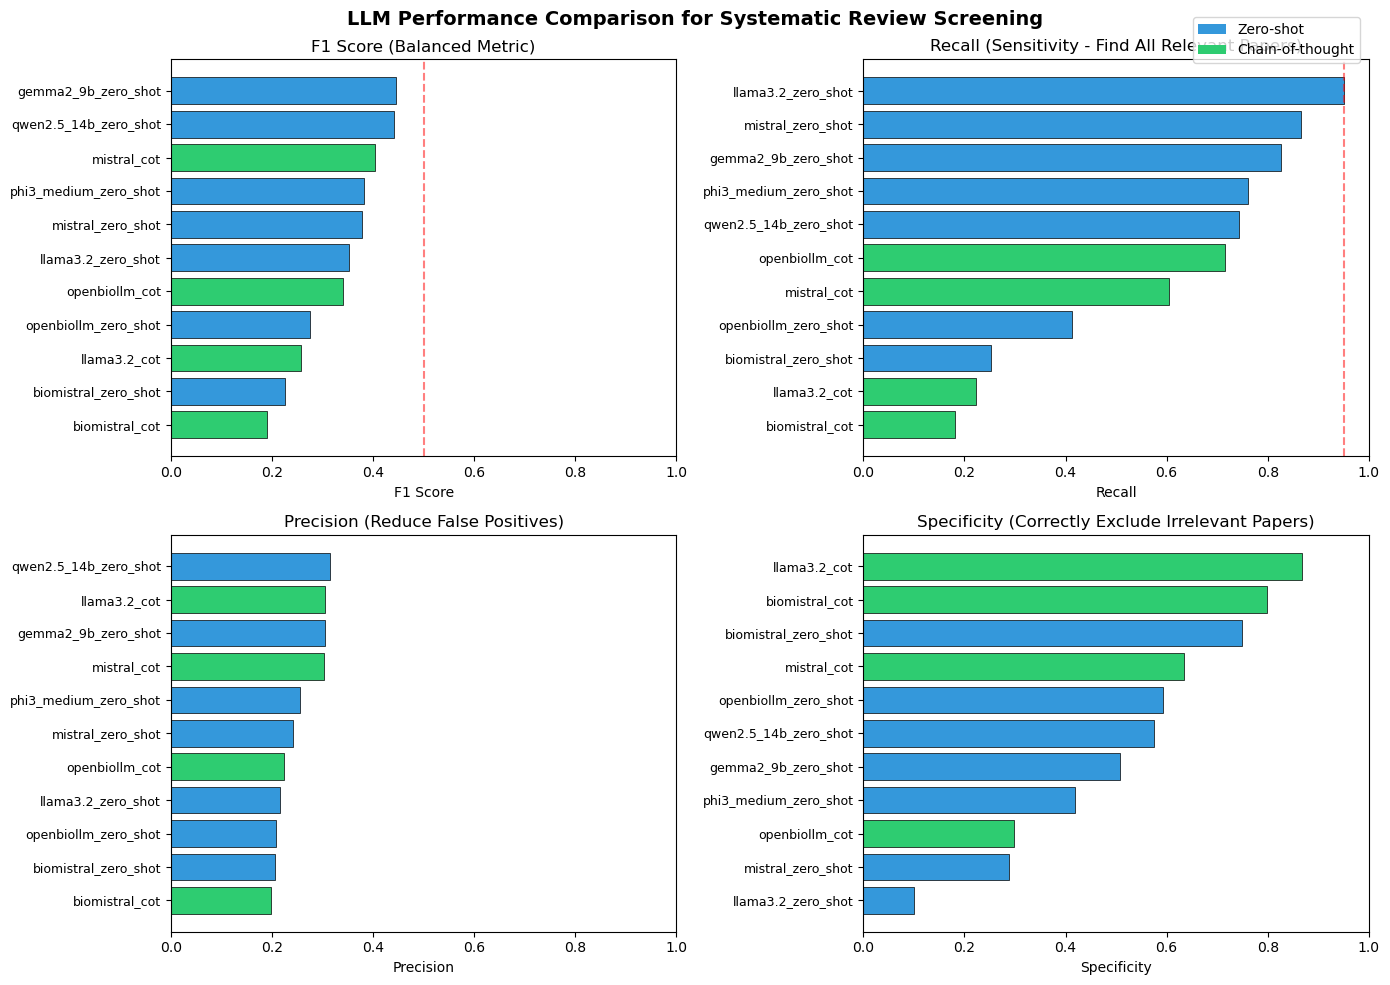


✓ Saved chart to model_comparison_chart.png

ZERO-SHOT vs CHAIN-OF-THOUGHT COMPARISON


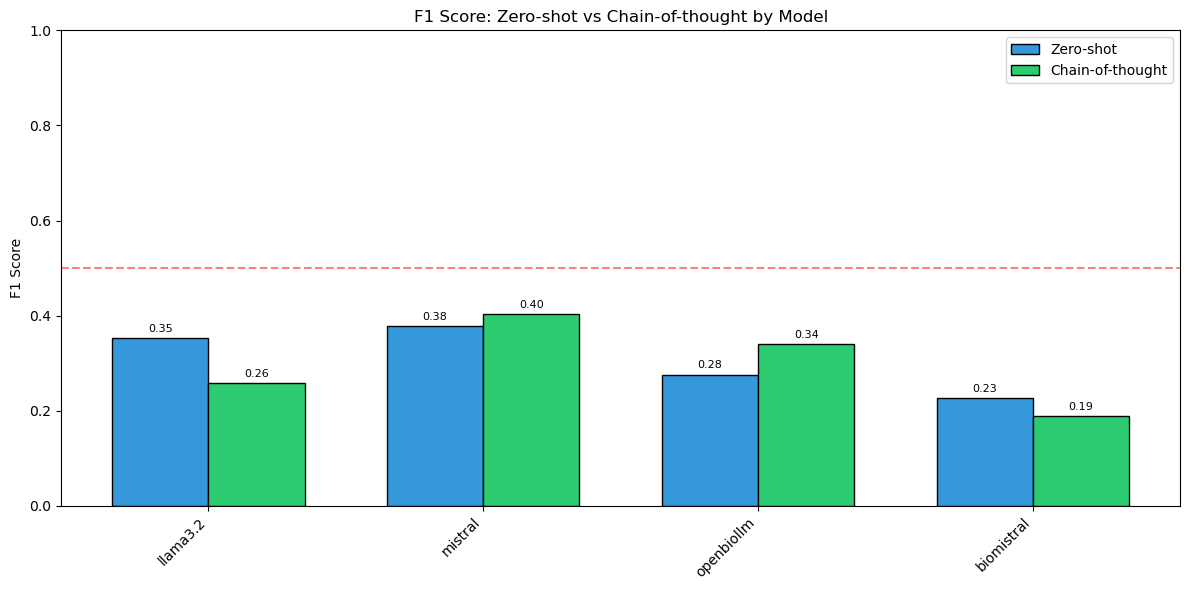

✓ Saved zero-shot vs CoT chart to zs_vs_cot_comparison.png


In [21]:
# =============================================================================
# Compare All Results (loads from saved files) + Visualizations
# =============================================================================
import glob
import re
import matplotlib.pyplot as plt
import numpy as np

print("=" * 80)
print("LOADING ALL RESULTS AND COMPARING")
print("=" * 80)

# Define all expected evaluations
all_models = ['llama3.2', 'llama3.1_8b', 'mistral', 'mixtral_8x7b', 'qwen2.5_14b', 
              'gemma2_9b', 'phi3_medium', 'openbiollm', 'biomistral', 'meditron_7b']
prompt_types = ['zero_shot', 'cot']
expected = {f"{m}_{p}" for m in all_models for p in prompt_types}

# Load all results from files
comparison_rows = []
result_files = sorted(glob.glob(str(RESULTS_DIR / "eval_*.csv")))
completed = set()

for filepath in result_files:
    filename = Path(filepath).name
    # Parse filename: eval_{model}_{prompt_type}_{date}_{time}.csv
    # Example: eval_gemma2_9b_zero_shot_20260208_105918.csv
    match = re.match(r'eval_(.+)_(zero_shot|cot)_\d{8}_\d{6}\.csv', filename)
    if not match:
        continue
    
    model_name = match.group(1)
    prompt_type = match.group(2)
    
    completed.add(f"{model_name}_{prompt_type}")
    
    df = pd.read_csv(filepath)
    valid = df[df['prediction'] != -1]
    if len(valid) == 0:
        continue
    
    tn = ((valid['label'] == 0) & (valid['prediction'] == 0)).sum()
    tp = ((valid['label'] == 1) & (valid['prediction'] == 1)).sum()
    fn = ((valid['label'] == 1) & (valid['prediction'] == 0)).sum()
    fp = ((valid['label'] == 0) & (valid['prediction'] == 1)).sum()
    
    total_in_file = len(df)
    comparison_rows.append({
        'model': model_name,
        'prompt_type': prompt_type,
        'model_prompt': f"{model_name}_{prompt_type}",
        'total_samples': total_in_file,
        'valid_preds': len(valid),
        'parse_rate': len(valid) / total_in_file * 100 if total_in_file > 0 else 0,
        'accuracy': accuracy_score(valid['label'], valid['prediction']),
        'precision': precision_score(valid['label'], valid['prediction'], zero_division=0),
        'recall': recall_score(valid['label'], valid['prediction'], zero_division=0),
        'f1': f1_score(valid['label'], valid['prediction'], zero_division=0),
        'specificity': tn / (tn + fp) if (tn + fp) > 0 else 0,
    })

comparison = pd.DataFrame(comparison_rows)
comparison = comparison.sort_values('f1', ascending=False)

# Progress summary
remaining = expected - completed
print(f"\n✓ Completed: {len(completed)}/20 evaluations")
print(f"✗ Remaining: {len(remaining)}/20 evaluations")
if remaining:
    print(f"  → {sorted(remaining)}")

print("\n" + "=" * 80)
print("IMPORTANT: Same validation dataset used for ALL models")
print("=" * 80)
print(f"• All models evaluated on the SAME {len(eval_data):,} Public Health samples")
print(f"• 'valid_preds' = responses successfully parsed as INCLUDE/EXCLUDE")
print(f"• 'parse_rate' = % of responses that could be parsed (lower = more invalid outputs)")
print(f"• Metrics computed only on valid predictions (invalid responses excluded)")

print("\n" + "=" * 80)
print("METRICS COMPARISON (sorted by F1)")
print("=" * 80)
display_cols = ['model_prompt', 'total_samples', 'valid_preds', 'parse_rate', 'accuracy', 'precision', 'recall', 'f1', 'specificity']
print(comparison[display_cols].to_string(index=False, float_format='{:.2f}'.format))

# Save comparison
comparison.to_csv(RESULTS_DIR / "model_comparison.csv", index=False)
print(f"\n✓ Saved comparison to model_comparison.csv")

# =============================================================================
# Visualization: Bar Charts
# =============================================================================
if len(comparison) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('LLM Performance Comparison for Systematic Review Screening', fontsize=14, fontweight='bold')
    
    # Sort by F1 for the plot
    plot_df = comparison.sort_values('f1', ascending=True)
    colors_sorted = ['#2ecc71' if pt == 'cot' else '#3498db' for pt in plot_df['prompt_type']]
    
    # 1. F1 Score
    ax1 = axes[0, 0]
    y_pos = np.arange(len(plot_df))
    ax1.barh(y_pos, plot_df['f1'], color=colors_sorted, edgecolor='black', linewidth=0.5)
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(plot_df['model_prompt'], fontsize=9)
    ax1.set_xlabel('F1 Score')
    ax1.set_title('F1 Score (Balanced Metric)')
    ax1.set_xlim(0, 1)
    ax1.axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='0.5 threshold')
    
    # 2. Recall (Sensitivity)
    ax2 = axes[0, 1]
    plot_df_recall = comparison.sort_values('recall', ascending=True)
    colors_recall = ['#2ecc71' if pt == 'cot' else '#3498db' for pt in plot_df_recall['prompt_type']]
    ax2.barh(y_pos, plot_df_recall['recall'], color=colors_recall, edgecolor='black', linewidth=0.5)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(plot_df_recall['model_prompt'], fontsize=9)
    ax2.set_xlabel('Recall')
    ax2.set_title('Recall (Sensitivity - Find All Relevant Papers)')
    ax2.set_xlim(0, 1)
    ax2.axvline(x=0.95, color='red', linestyle='--', alpha=0.5, label='95% target')
    
    # 3. Precision
    ax3 = axes[1, 0]
    plot_df_prec = comparison.sort_values('precision', ascending=True)
    colors_prec = ['#2ecc71' if pt == 'cot' else '#3498db' for pt in plot_df_prec['prompt_type']]
    ax3.barh(y_pos, plot_df_prec['precision'], color=colors_prec, edgecolor='black', linewidth=0.5)
    ax3.set_yticks(y_pos)
    ax3.set_yticklabels(plot_df_prec['model_prompt'], fontsize=9)
    ax3.set_xlabel('Precision')
    ax3.set_title('Precision (Reduce False Positives)')
    ax3.set_xlim(0, 1)
    
    # 4. Specificity
    ax4 = axes[1, 1]
    plot_df_spec = comparison.sort_values('specificity', ascending=True)
    colors_spec = ['#2ecc71' if pt == 'cot' else '#3498db' for pt in plot_df_spec['prompt_type']]
    ax4.barh(y_pos, plot_df_spec['specificity'], color=colors_spec, edgecolor='black', linewidth=0.5)
    ax4.set_yticks(y_pos)
    ax4.set_yticklabels(plot_df_spec['model_prompt'], fontsize=9)
    ax4.set_xlabel('Specificity')
    ax4.set_title('Specificity (Correctly Exclude Irrelevant Papers)')
    ax4.set_xlim(0, 1)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='#3498db', label='Zero-shot'),
                       Patch(facecolor='#2ecc71', label='Chain-of-thought')]
    fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.98))
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'model_comparison_chart.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\n✓ Saved chart to model_comparison_chart.png")
    
    # =============================================================================
    # Comparison: Zero-shot vs Chain-of-thought
    # =============================================================================
    print("\n" + "=" * 80)
    print("ZERO-SHOT vs CHAIN-OF-THOUGHT COMPARISON")
    print("=" * 80)
    
    # Find models with both prompt types
    models_with_both = []
    for m in all_models:
        if f"{m}_zero_shot" in completed and f"{m}_cot" in completed:
            models_with_both.append(m)
    
    if len(models_with_both) > 0:
        fig2, ax = plt.subplots(figsize=(12, 6))
        
        x = np.arange(len(models_with_both))
        width = 0.35
        
        zs_f1 = [comparison[(comparison['model'] == m) & (comparison['prompt_type'] == 'zero_shot')]['f1'].values[0] 
                 for m in models_with_both]
        cot_f1 = [comparison[(comparison['model'] == m) & (comparison['prompt_type'] == 'cot')]['f1'].values[0] 
                  for m in models_with_both]
        
        bars1 = ax.bar(x - width/2, zs_f1, width, label='Zero-shot', color='#3498db', edgecolor='black')
        bars2 = ax.bar(x + width/2, cot_f1, width, label='Chain-of-thought', color='#2ecc71', edgecolor='black')
        
        ax.set_ylabel('F1 Score')
        ax.set_title('F1 Score: Zero-shot vs Chain-of-thought by Model')
        ax.set_xticks(x)
        ax.set_xticklabels(models_with_both, rotation=45, ha='right')
        ax.legend()
        ax.set_ylim(0, 1)
        ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5)
        
        # Add value labels
        for bar in bars1:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
        for bar in bars2:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
        
        plt.tight_layout()
        plt.savefig(RESULTS_DIR / 'zs_vs_cot_comparison.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(f"✓ Saved zero-shot vs CoT chart to zs_vs_cot_comparison.png")
    else:
        print("Not enough models with both prompt types for comparison yet.")

In [20]:
# =============================================================================
# Summary and Key Findings
# =============================================================================
print("\n" + "=" * 80)
print("EVALUATION SUMMARY")
print("=" * 80)

print(f"\n📊 DATASET")
print(f"   • Public Health subset: {len(eval_data):,} samples")
print(f"   • Ground truth available: {len(ground_truth):,} examples")
print(f"   • Included papers: {(eval_data['label']==1).sum():,} ({(eval_data['label']==1).mean()*100:.1f}%)")
print(f"   • Excluded papers: {(eval_data['label']==0).sum():,} ({(eval_data['label']==0).mean()*100:.1f}%)")

print(f"\n🤖 MODELS EVALUATED")
print("   General-Purpose (7): Llama 3.2, Llama 3.1 8B, Mistral 7B, Mixtral 8x7B,")
print("                        Qwen 2.5 14B, Gemma 2 9B, Phi-3 Medium 14B")
print("   Biomedical (3):      OpenBioLLM-8B, BioMistral 7B, Meditron 7B")
print(f"\n   Prompt types: Zero-shot, Chain-of-thought")
print(f"   Total experiments: 10 models × 2 prompts = 20 evaluations")

# Key findings from completed evaluations
if len(comparison) > 0:
    print(f"\n📈 KEY FINDINGS (from {len(comparison)} completed evaluations)")
    print("-" * 60)
    
    best_f1 = comparison.loc[comparison['f1'].idxmax()]
    best_recall = comparison.loc[comparison['recall'].idxmax()]
    best_precision = comparison.loc[comparison['precision'].idxmax()]
    
    print(f"   Best F1 Score:    {best_f1['model_prompt']:<25} F1={best_f1['f1']:.4f}")
    print(f"   Best Recall:      {best_recall['model_prompt']:<25} Recall={best_recall['recall']:.4f}")
    print(f"   Best Precision:   {best_precision['model_prompt']:<25} Precision={best_precision['precision']:.4f}")
    
    # Models with >95% recall (important for screening)
    high_recall = comparison[comparison['recall'] >= 0.95]
    if len(high_recall) > 0:
        print(f"\n   ✓ Models with ≥95% recall (suitable for screening):")
        for _, row in high_recall.iterrows():
            print(f"     - {row['model_prompt']}: Recall={row['recall']:.4f}, Precision={row['precision']:.4f}")
    else:
        print(f"\n   ⚠ No models achieved ≥95% recall yet")
    
    # Average metrics by prompt type
    print(f"\n   Average metrics by prompt type:")
    for pt in ['zero_shot', 'cot']:
        pt_data = comparison[comparison['prompt_type'] == pt]
        if len(pt_data) > 0:
            print(f"     {pt:12}: F1={pt_data['f1'].mean():.4f}, Recall={pt_data['recall'].mean():.4f}, Precision={pt_data['precision'].mean():.4f}")

print(f"\n📁 OUTPUTS")
print(f"   Results directory: {RESULTS_DIR}")
print(f"   • Individual results: eval_{{model}}_{{prompt}}_{{timestamp}}.csv")
print(f"   • Comparison table:   model_comparison.csv")
print(f"   • Charts:             model_comparison_chart.png, zs_vs_cot_comparison.png")

print(f"\n✓ All inference was LOCAL via Ollama - no data sent to external APIs.")
print("=" * 80)


EVALUATION SUMMARY

📊 DATASET
   • Public Health subset: 4,089 samples
   • Ground truth available: 41,692 examples
   • Included papers: 848 (20.7%)
   • Excluded papers: 3,241 (79.3%)

🤖 MODELS EVALUATED
   General-Purpose (7): Llama 3.2, Llama 3.1 8B, Mistral 7B, Mixtral 8x7B,
                        Qwen 2.5 14B, Gemma 2 9B, Phi-3 Medium 14B
   Biomedical (3):      OpenBioLLM-8B, BioMistral 7B, Meditron 7B

   Prompt types: Zero-shot, Chain-of-thought
   Total experiments: 10 models × 2 prompts = 20 evaluations

📈 KEY FINDINGS (from 11 completed evaluations)
------------------------------------------------------------
   Best F1 Score:    gemma2_9b_zero_shot       F1=0.4459
   Best Recall:      llama3.2_zero_shot        Recall=0.9505
   Best Precision:   qwen2.5_14b_zero_shot     Precision=0.3141

   ✓ Models with ≥95% recall (suitable for screening):
     - llama3.2_zero_shot: Recall=0.9505, Precision=0.2164

   Average metrics by prompt type:
     zero_shot   : F1=0.3576, Recall